In [2]:
import torch
import torch.nn as nn
from face_classifier import *
import warnings
from Models.resnet import IBugFaceKeypointResNet50
from cnn_utils import *
import numpy as np
from torch.utils.data import DataLoader
import random

warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

### Facial Keypoint Detection using the IBug Image Database for Training Data
### Code written by Luke Banaszak or Rick Suggs unless otherwise noted
#### This notebook employs techniques inspired and adapted from this blog post / tutorial:
https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

In [7]:
# WARNING! This is a large download ~(2GB)
# download_ibug_face_database()

# Data Pipeline

In [8]:
# Put together the transformations we'll perform on the input images
composed = transforms.Compose(
    [Crop(), Rescale((224, 224)), NormalizeZeroToOne(), ToColor(), ToTensor()]
)

In [9]:
dataset = IBugFaceLandmarksDataset(transform=composed)

# split the dataset into validation and test sets
len_test_set = int(0.1 * len(dataset))
len_train_set = len(dataset) - len_test_set

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [len_train_set, len_test_set]
)

print(f"Training sample instances: {len(train_dataset)}")
print(f"Validation sample instances: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=0)

Training sample instances: 5877
Validation sample instances: 653


In [10]:
print(f"GPU acceleration is available: {torch.cuda.is_available()}")

resnet50_model = IBugFaceKeypointResNet50(True, True)

if torch.cuda.is_available():
    resnet50_model.cuda()

GPU acceleration is available: True
Training intermediate layer parameters...


### Sample some output before training the model on the IBug Image Dataset
### The green keypoints are ground truth points

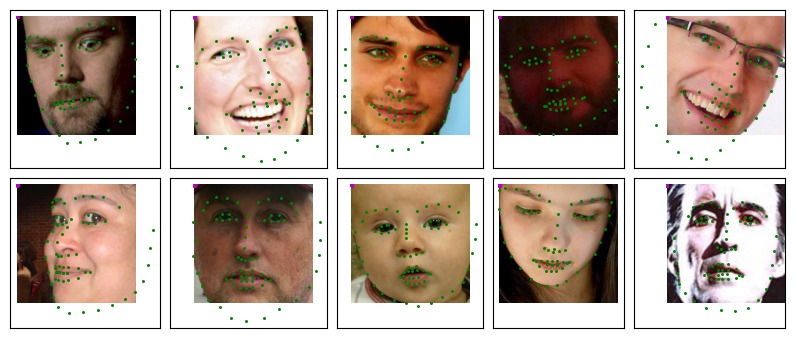

In [6]:
for test_images, test_outputs, gt_pts in net_sample_output(
    resnet50_model, test_dataloader, num_keypoints=68
):
    visualize_output(test_images, test_outputs, gt_pts)

# Optimizer and Training

In [11]:
# Define loss function as mean squared error
# Use ADAM algorithm as optimizer
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0003, fused=True)

In [8]:
# WARNING! This cell takes several hours to execute
# About 10 epochs are required for good results
# The trained model can be downloaded from https://drive.google.com/file/d/1luxLEy6aK5yr1dDLNwNMVpOQown8Hsr9
# and unzipped to the nets folder. Scroll down 4 cells and it can be loaded from the saved model file.
training_loss, validation_loss = train_and_validate(
    resnet50_model, train_dataloader, optimizer, criterion, test_dataloader, 1
)

Epoch: 1, Batch: 10, Avg. Training Loss: 17365.5837890625
Epoch: 1, Batch: 20, Avg. Training Loss: 16698.289697265624
Epoch: 1, Batch: 30, Avg. Training Loss: 16172.224674479166
Epoch: 1, Batch: 40, Avg. Training Loss: 15514.643505859374
Epoch: 1, Batch: 50, Avg. Training Loss: 14996.48333984375
Epoch: 1, Batch: 60, Avg. Training Loss: 14399.657194010417
Epoch: 1, Batch: 70, Avg. Training Loss: 13826.720452008929
Epoch: 1, Batch: 80, Avg. Training Loss: 13281.427307128906
Epoch: 1, Batch: 90, Avg. Training Loss: 12742.68583984375
Epoch: 1, Batch: 100, Avg. Training Loss: 12230.449047851562
Epoch: 1, Batch: 110, Avg. Training Loss: 11719.157839133522
Epoch: 1, Batch: 120, Avg. Training Loss: 11235.339286295573
Epoch: 1, Batch: 130, Avg. Training Loss: 10776.586545973558
Epoch: 1, Batch: 140, Avg. Training Loss: 10337.061148507255
Epoch: 1, Batch: 150, Avg. Training Loss: 9921.109449869791
Epoch: 1, Batch: 160, Avg. Training Loss: 9524.995429992676
Epoch: 1, Batch: 170, Avg. Training Los

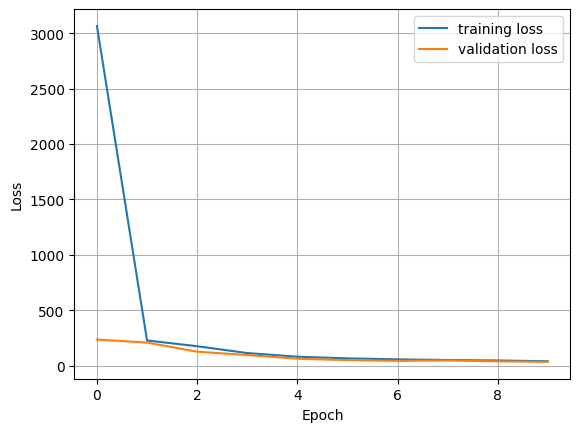

In [9]:
plt.figure()
plt.plot(training_loss, label="training loss")
plt.plot(validation_loss, label="validation loss")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

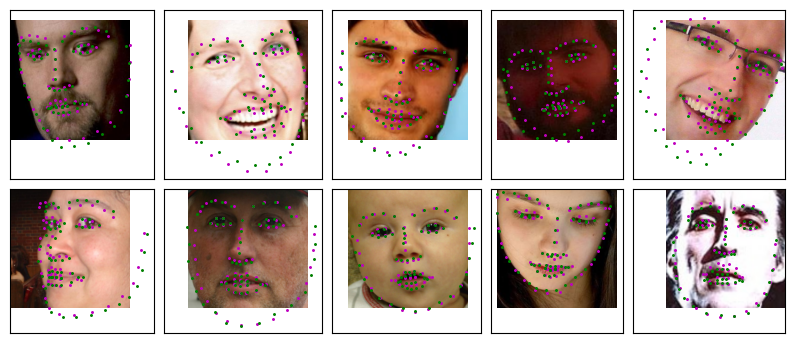

In [10]:
for test_images, test_outputs, gt_pts in net_sample_output(
    resnet50_model, test_dataloader, num_keypoints=68
):
    visualize_output(test_images, test_outputs, gt_pts)

In [75]:
state = {
    "epoch": 25,
    "model_state_dict": resnet50_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": criterion,
}
torch.save(state, "nets/resnet50-ibug_1_landmarks.pth")

In [12]:
# The trained model can be downloaded from: https://drive.google.com/file/d/1luxLEy6aK5yr1dDLNwNMVpOQown8Hsr9
# and unzipped into the nets folder
best_network = IBugFaceKeypointResNet50(True, True)
checkpoint = torch.load("nets/resnet50-ibug_1_landmarks.pth")
best_network.load_state_dict(checkpoint["model_state_dict"])
if torch.cuda.is_available():
    best_network.cuda()
best_network.eval();


Training intermediate layer parameters...


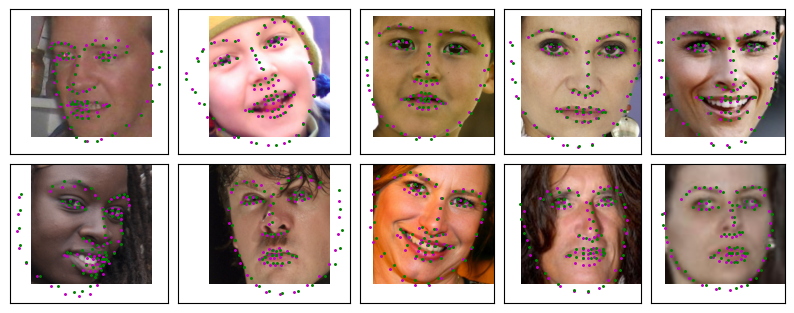

In [13]:

for test_images, test_outputs, gt_pts in net_sample_output(
    best_network, test_dataloader, num_keypoints=68
):
    visualize_output(test_images, test_outputs, gt_pts)

In [14]:
def post_transform(keypoints, bbox):
    # un-rescale from (224, 224)
    keypoints_t = keypoints.T
    keypoints_t = keypoints_t * np.array([bbox[2] / 224, bbox[3] / 224])
    # un-crop
    keypoints_t = keypoints_t + np.array([[bbox[1], bbox[0]]])

    return keypoints_t.T


# used to detect face in input image to feed into model
frontal_face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(frontal_face_cascade_path)

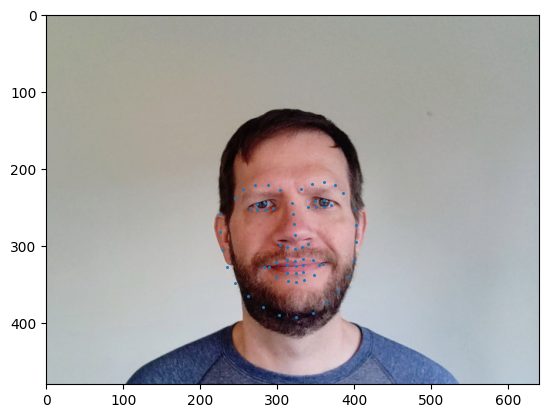

In [15]:
image = cv2.imread("../FaceMorphing/images/rick_640x480.jpg").astype(np.uint8)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.equalizeHist(image_gray)
faces = face_cascade.detectMultiScale(image_gray)

left, top, width, height = faces[0]

bbox = [top, left, width, height]

predicted_key_pts = get_predicted_keypoints(
    image_rgb.astype(np.float32),
    composed,
    best_network,
    bbox=bbox,
    num_keypoints=68,
    post_transform=post_transform,
)

np.save(
    "../FaceMorphing/keypoints/rick_640x480_ibug_predicted_points.npy",
    predicted_key_pts.T,
)

cropped_image = image[top : top + height, left : left + width]
plt.imshow(image_rgb)
plt.scatter(*predicted_key_pts, s=5, marker=".")

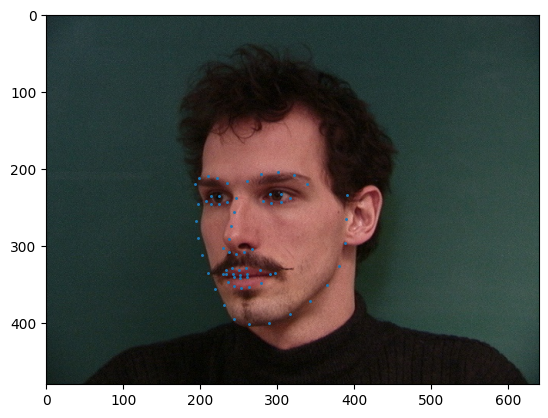

In [16]:
image = cv2.imread("Data/10-3m.jpg").astype(np.uint8)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.equalizeHist(image_gray)
faces = face_cascade.detectMultiScale(image_gray)

left, top, width, height = faces[0]

bbox = [top, left, width, height]

predicted_key_pts = get_predicted_keypoints(
    image_rgb.astype(np.float32),
    composed,
    best_network,
    bbox=bbox,
    num_keypoints=68,
    post_transform=post_transform,
)

np.save(
    "../FaceMorphing/keypoints/10-3m_ibug_predicted_points.npy",
    predicted_key_pts.T,
)

cropped_image = image[top : top + height, left : left + width]
plt.imshow(image_rgb)
plt.scatter(*predicted_key_pts, s=5, marker=".")

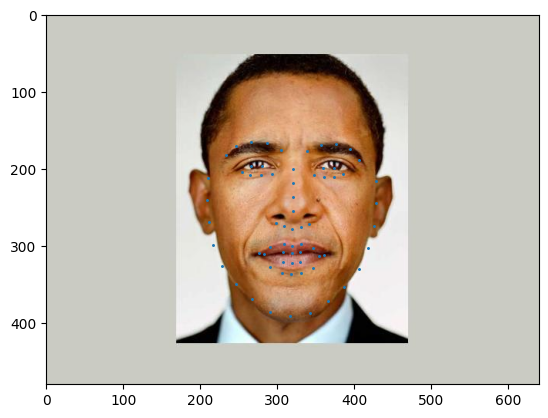

In [17]:
image = cv2.imread("../FaceMorphing/images/barack_640x480.jpg").astype(np.uint8)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.equalizeHist(image_gray)
faces = face_cascade.detectMultiScale(image_gray)

left, top, width, height = faces[0]

bbox = [top, left, width, height]

predicted_key_pts = get_predicted_keypoints(
    image_rgb.astype(np.float32),
    composed,
    best_network,
    bbox=bbox,
    num_keypoints=68,
    post_transform=post_transform,
)

np.save(
    "../FaceMorphing/keypoints/barack_640x480_ibug_predicted_points.npy",
    predicted_key_pts.T,
)

cropped_image = image[top : top + height, left : left + width]
plt.imshow(image_rgb)
plt.scatter(*predicted_key_pts, s=5, marker=".")

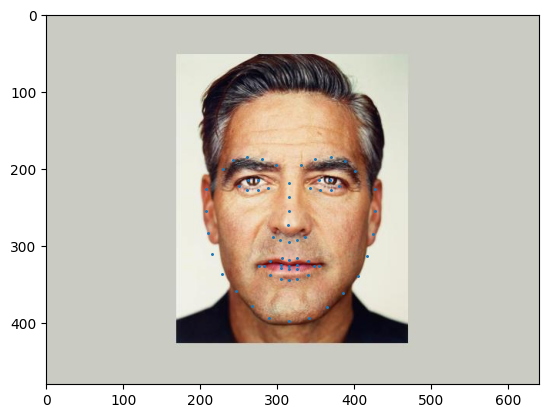

In [18]:
image = cv2.imread("../FaceMorphing/images/george_640x480.jpg").astype(np.uint8)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.equalizeHist(image_gray)
faces = face_cascade.detectMultiScale(image_gray)

left, top, width, height = faces[0]

bbox = [top, left, width, height]

predicted_key_pts = get_predicted_keypoints(
    image_rgb.astype(np.float32),
    composed,
    best_network,
    bbox=bbox,
    num_keypoints=68,
    post_transform=post_transform,
)

np.save(
    "../FaceMorphing/keypoints/george_640x480_ibug_predicted_points.npy",
    predicted_key_pts.T,
)

cropped_image = image[top : top + height, left : left + width]
plt.imshow(image_rgb)
plt.scatter(*predicted_key_pts, s=5, marker=".")

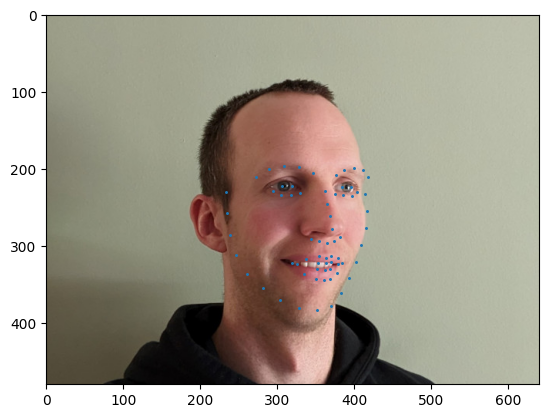

In [19]:
image = cv2.imread("../FaceMorphing/images/tlb1_640x480.jpg").astype(np.uint8)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.equalizeHist(image_gray)
faces = face_cascade.detectMultiScale(image_gray)

left, top, width, height = faces[0]

bbox = [top, left, width, height]

predicted_key_pts = get_predicted_keypoints(
    image_rgb.astype(np.float32),
    composed,
    best_network,
    bbox=bbox,
    num_keypoints=68,
    post_transform=post_transform,
)

np.save(
    "../FaceMorphing/keypoints/tlb1_640x480_ibug_predicted_points.npy",
    predicted_key_pts.T,
)

cropped_image = image[top : top + height, left : left + width]
plt.imshow(image_rgb)
plt.scatter(*predicted_key_pts, s=5, marker=".")

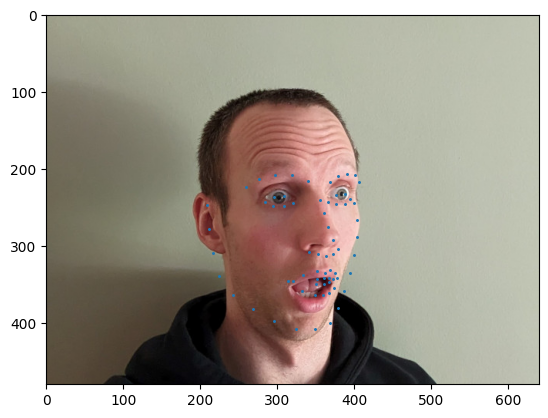

In [20]:
image = cv2.imread("../FaceMorphing/images/tlb2_640x480.jpg").astype(np.uint8)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.equalizeHist(image_gray)
faces = face_cascade.detectMultiScale(image_gray)

left, top, width, height = faces[0]

bbox = [top, left, width, height]

predicted_key_pts = get_predicted_keypoints(
    image_rgb.astype(np.float32),
    composed,
    best_network,
    bbox=bbox,
    num_keypoints=68,
    post_transform=post_transform,
)

np.save(
    "../FaceMorphing/keypoints/tlb2_640x480_ibug_predicted_points.npy",
    predicted_key_pts.T,
)

cropped_image = image[top : top + height, left : left + width]
plt.imshow(image_rgb)
plt.scatter(*predicted_key_pts, s=5, marker=".")

In [ ]:
# WARNING! This cell takes several minutes to execute

images = []

for i in range(1, 41):
    pose = random.randint(1, 6)
    person = i if i > 9 else f'0{i}'

    g = 'm' if os.path.exists(f"Data/{person}-{pose}m.jpg") else 'f'
    image = cv2.imread(f"Data/{person}-{pose}{g}.jpg").astype(np.uint8)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.equalizeHist(image_gray)
    faces = face_cascade.detectMultiScale(image_gray)

    left, top, width, height = faces[0]

    bbox = [top, left, width, height]

    predicted_key_pts = get_predicted_keypoints(
        image_rgb.astype(np.float32),
        composed,
        best_network,
        bbox=bbox,
        num_keypoints=68,
        post_transform=post_transform,
    )

    np.save(
        f"../FaceMorphing/keypoints/batch1/{person}-{pose}{g}_ibug_predicted_points.npy",
        predicted_key_pts.T,
    )